**'What If?' Stock Investment Simulator**

This project allows users to simulate past stock investments and analyze how their money would have grown over time.  
Users can choose a stock, set a time period, and select an investment strategy:  
1. **Lump-Sum Investment** - Invest a fixed amount on a specific date.  
2. **Monthly Investment (Dollar-Cost Averaging)** - Invest a fixed amount every month over time.  
3. **Buy-the-Dip Strategy** - Invest only when stock prices drop below a certain level.  

The program retrieves historical stock data, calculates potential returns, and visualizes investment performance.  
It's a financial "time machine" that helps users understand investment growth without actual risk.  

In [1]:
from flask import Flask, render_template, request
import pandas as pd
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'flask'

In [ ]:
app = Flask(__name__)


In [ ]:
# Function to fetch stock data
def get_stock_data(ticker, start_date, end_date):
    """
    Fetches stock data for the specified ticker between the given start and end dates.

    Args:
    ticker (str): The stock ticker symbol (e.g., AAPL, TSLA).
    start_date (str): The start date for the stock data (format: YYYY-MM-DD).
    end_date (str): The end date for the stock data (format: YYYY-MM-DD).

    Returns:
    pd.DataFrame: A DataFrame containing the closing prices of the stock.
    """
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df = df[['Close']]  # Keep only the closing price
    df.index = pd.to_datetime(df.index)  # Ensure index is in datetime format
    return df


In [ ]:
# Function to store stock data in SQL database
def store_data_in_sql(df, ticker):
    """
    Stores the fetched stock data into a SQLite database.

    Args:
    df (pd.DataFrame): The DataFrame containing stock data to be stored.
    ticker (str): The stock ticker symbol that identifies the table in the database.

    Returns:
    None
    """
    conn = sqlite3.connect("stocks.db")
    df.reset_index(inplace=True)
    df.to_sql(ticker, conn, if_exists="replace", index=False)
    conn.close()
    print(f"Stock data stored in database: {ticker}")


In [ ]:
# Function to print stored stock data
def print_stored_data(ticker):
    conn = sqlite3.connect("stocks.db")
    query = f"SELECT * FROM {ticker} LIMIT 10;"  # Print only first 10 rows
    df = pd.read_sql(query, conn)
    conn.close()
    print(f"\nStored stock data for {ticker} (First 10 rows):\n")
    print(df)


In [ ]:
# Function for Lump-Sum Investment
def lump_sum_investment(df, investment_amount, buy_date):
    """
    Simulates a lump-sum investment by purchasing stocks at the given buy date and holding until the end date.

    Args:
    df (pd.DataFrame): The DataFrame containing stock data (with closing prices).
    investment_amount (float): The amount of money to invest in the stock.
    buy_date (str): The date when the lump-sum investment is made (format: YYYY-MM-DD).

    Returns:
    tuple: The number of shares bought and the final value of the investment.
    """
    # Convert the buy_date to datetime and remove the time zone
    buy_date = pd.to_datetime(buy_date).normalize()  # Normalize to remove time portion

    # Convert the DataFrame index to DatetimeIndex if it's not already
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index(pd.to_datetime(df['Date']))  # Assuming 'Date' column exists

    # Strip timezone from the stock data to make sure it's comparable
    df.index = df.index.tz_localize(None)  # Remove timezone info

    # Check if the buy_date is in the data index
    if buy_date not in df.index:
        print("Invalid date. Try again!")
        return None, None

    # Retrieve buy price and calculate investment details
    buy_price = df.loc[buy_date, "Close"]
    shares_bought = investment_amount / buy_price
    final_value = shares_bought * df.iloc[-1]["Close"]

    return shares_bought, final_value


In [ ]:
# Function for Monthly Investment (Dollar-Cost Averaging)
def monthly_investment(df, monthly_amount, start_date):
    """
    Simulates monthly investments by making fixed amount investments every month, starting from the given start date.

    Args:
    df (pd.DataFrame): The DataFrame containing stock data (with closing prices).
    monthly_amount (float): The amount to invest each month.
    start_date (str): The start date for the monthly investments (format: YYYY-MM-DD).

    Returns:
    tuple: The total number of shares bought and the final value of the investment.
    """
    start_date = pd.to_datetime(start_date)  # Convert input date to datetime
    total_shares = 0

    if start_date not in df.index:
        print("Invalid start date. Try again!")
        return None, None

    for date in df[start_date:].resample('M').first().index:  # Every month
        if date in df.index:  # Ensure valid market date
            price = df.loc[date, "Close"]
            shares = monthly_amount / price
            total_shares += shares

    final_value = total_shares * df.iloc[-1]["Close"]
    return total_shares, final_value


In [ ]:
# Function for Buy-the-Dip Strategy
def buy_the_dip(df, investment_amount, threshold=0.95):
    """
    Simulates a buy-the-dip strategy where stocks are bought if the price drops by a certain percentage.

    Args:
    df (pd.DataFrame): The DataFrame containing stock data (with closing prices).
    investment_amount (float): The amount of money to invest whenever a dip is detected.
    threshold (float): The percentage threshold for detecting a dip (default is 95% or 5% drop).

    Returns:
    tuple: The total number of shares bought and the final value of the investment.
    """
    total_shares = 0
    last_price = None

    for date, row in df.iterrows():
        price = row["Close"]
        if last_price and price < last_price * threshold:  # If price drops 5%+
            shares = investment_amount / price
            total_shares += shares
        last_price = price

    final_value = total_shares * df.iloc[-1]["Close"]
    return total_shares, final_value


In [ ]:
# Function to plot stock data
def plot_stock_data(df):
    """
    Plots the stock's closing price over time.

    Args:
    df (pd.DataFrame): The DataFrame containing stock data (with closing prices).

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Stock Price", color='blue')
    plt.title("Stock Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()


In [ ]:
# Main Program Execution
print("Welcome to the 'What If?' Stock Investment Simulator!\n")

# User inputs
ticker = input("Enter the stock ticker symbol (e.g., AAPL, TSLA, GOOG): ").upper()
start_date = input("Enter the start date for analysis (YYYY-MM-DD): ")
end_date = input("Enter the end date for analysis (YYYY-MM-DD): ")


Welcome to the 'What If?' Stock Investment Simulator!

Enter the stock ticker symbol (e.g., AAPL, TSLA, GOOG): TSLA
Enter the start date for analysis (YYYY-MM-DD): 2025-01-01
Enter the end date for analysis (YYYY-MM-DD): 2065-01-01


In [ ]:
# Fetch and store stock data
stock_data = get_stock_data(ticker, start_date, end_date)
store_data_in_sql(stock_data, ticker)

# Print stored data
print_stored_data(ticker)

# Investment strategy selection
print("\n Choose your investment strategy:")
print("1. Lump-Sum Investment")
print("2. Monthly Investment (Dollar-Cost Averaging)")
print("3. Buy-the-Dip Strategy")


Stock data stored in database: TSLA

Stored stock data for TSLA (First 10 rows):

                        Date       Close
0  2025-01-02 00:00:00-05:00  379.279999
1  2025-01-03 00:00:00-05:00  410.440002
2  2025-01-06 00:00:00-05:00  411.049988
3  2025-01-07 00:00:00-05:00  394.359985
4  2025-01-08 00:00:00-05:00  394.940002
5  2025-01-10 00:00:00-05:00  394.739990
6  2025-01-13 00:00:00-05:00  403.309998
7  2025-01-14 00:00:00-05:00  396.359985
8  2025-01-15 00:00:00-05:00  428.220001
9  2025-01-16 00:00:00-05:00  413.820007

 Choose your investment strategy:
1. Lump-Sum Investment
2. Monthly Investment (Dollar-Cost Averaging)
3. Buy-the-Dip Strategy


In [ ]:
choice = input("Enter the number of your choice: ").strip()

investment_amount = float(input("Enter the investment amount ($): "))

# Execute chosen strategy
if choice in {"1", "2", "3"}:
    if choice == "1":
        buy_date = input("Enter the lump-sum purchase date (YYYY-MM-DD): ").strip()
        shares, final_value = lump_sum_investment(stock_data, investment_amount, buy_date)
    elif choice == "2":
        start_date = input("Enter the start date for monthly investments (YYYY-MM-DD): ").strip()
        shares, final_value = monthly_investment(stock_data, investment_amount, start_date)
    else:  # choice == "3"
        shares, final_value = buy_the_dip(stock_data, investment_amount)

    # Display results
    if shares is not None and final_value is not None:
        print(f"\nTotal Shares Purchased: {shares:.2f}")
        print(f"Final Investment Value: ${final_value:.2f}")
else:
    print("Invalid choice. Exiting program.")
    exit()


Enter the number of your choice: 1
Enter the investment amount ($): 2000
Enter the lump-sum purchase date (YYYY-MM-DD): 2025-01-02

Total Shares Purchased: 5.27
Final Investment Value: $1579.89



Investment Simulation Completed!
You bought 5.27 shares, and your portfolio is now worth $1579.89.


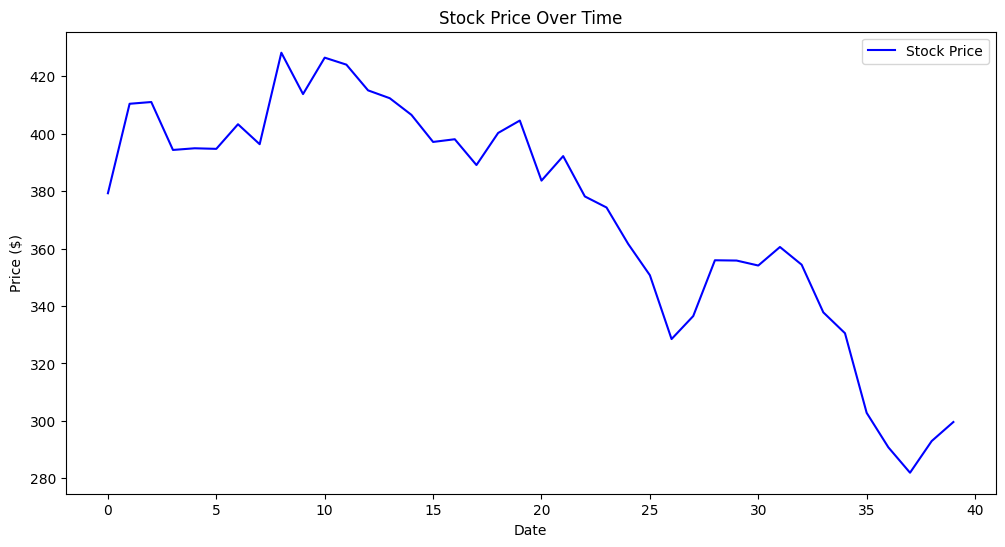

In [ ]:
# Display results
if shares and final_value:
    print(f"\nInvestment Simulation Completed!")
    print(f"You bought {shares:.2f} shares, and your portfolio is now worth ${final_value:.2f}.")

# Plot stock data
plot_stock_data(stock_data)


In [ ]:
@app.route("/", methods=["GET", "POST"])
def index():
    stock_data = None
    if request.method == "POST":
        ticker = request.form["ticker"].upper()
        start_date = request.form["start_date"]
        end_date = request.form["end_date"]

        stock_data = get_stock_data(ticker, start_date, end_date)
        if stock_data is not None and not stock_data.empty:
            store_data_in_sql(stock_data, ticker)
            stock_data = stock_data.head(10).to_html()  # Convert to HTML table

    return render_template("index.html", stock_data=stock_data)

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
